In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
import os
import numpy as np
import math
from tqdm import tqdm
from sklearn import metrics
import time

In [2]:
plt.rcParams["font.size"] = 20
plt.rcParams["font.family"] = "Times New Roman"
def make_data(lst, dim):
    lst=pd.DataFrame(lst)
    lst.columns=['data']
    window=dim
    str='data'
    for i in range(1, window):
        column=f'{str}_lag{i}'
        lst[column]=lst[str].shift(i)
    lst=lst.dropna().reset_index(drop=True)
    return lst.values

def calc_leq(df, unit):
    df.reset_index(inplace=True, drop=True)
    for i in range(int(len(df)/unit)+1):
        hour_df=df.loc[i*unit:(i+1)*unit, 'original'].copy()
        N=len(hour_df)
        Leq=10*np.log10(np.sum(np.power(10, hour_df/10)))-10*np.log10(N)
        df.loc[i*unit:(i+1)*unit, 'leq']=Leq
    return df

def leq_filter(df):
    df=calc_leq(df, 18000)
    df.loc[(df['original']<df['leq']), 'd']=0
    return df

def validate(test_v, anorm, thr):
    test_v['z']=np.where(anorm>=thr, 1, 0)
    test_v.reset_index(inplace=True, drop=True)
    
    #     適合率
    tp=test_v[(test_v['label']==1)&(test_v['z']==1)]
    z_p=test_v[test_v['z']==1]
    
    try:
        pre_score=len(tp)/len(z_p)
    except ZeroDivisionError:
        print(f'閾値{thr}　-->　ZeroDivisionError')
        pre_score=0

    #     再現率
    df_anorm=[]
    search= 1 if test_v.loc[0, 'label']==0 else 0
    start=0
    for num in range(len(test_v)):
        if search==1 and test_v.loc[num, 'label']==search:
            start=num
            search=0
        elif search==0 and test_v.loc[num, 'label']==search:
            stop=num-1
            anorm_range=test_v.loc[start:stop].copy()
            df_anorm.append(anorm_range)
            search=1
            
    count=[]
    for i in range(len(df_anorm)):
        if len(df_anorm[i].loc[df_anorm[i]['z']==1])>=1:
               count.append(i)    

    re_score=len(count)/len(df_anorm)

    return pre_score, re_score

def figure(df_test, anorm, d, thr):
    plt.rcParams["font.size"] = 20
    plt.rcParams["font.family"] = "Times New Roman"
    df_test['z']=np.where(d>=thr, 1, 0)
    
    z=df_test['z'].values*100
    test_plot=df_test['original'].values
    num_ax=math.ceil(len(test_plot)/17999)
    label=df_test['label'].values*100
    label_index=range(len(label))
    time_unit=60
    time=[t*0.2/60 for t in range(len(anorm))]
    time_unit_data=18000
    fig, ax=plt.subplots(num_ax, 1, figsize=(35, 16*num_ax))
    plt.subplots_adjust(hspace=0.35)
    for i in range(num_ax):
        ax[i].plot(time[i*time_unit_data:time_unit_data*(i+1)], anorm[i*time_unit_data:time_unit_data*(i+1)], '-r',linewidth = 1, label='異常度')
        ax[i].fill_between(time[i*time_unit_data:time_unit_data*(i+1)], label[i*time_unit_data:time_unit_data*(i+1)], facecolor='lime', label='異常ラベル' )
#         #異常と判別したところを強調したい場合
#         ax[i].fill_between(time[i*time_unit_data:time_unit_data*(i+1)], z[i*time_unit_data:time_unit_data*(i+1)], facecolor='coral' )
        
        ax2=ax[i].twinx()
        ax2.plot(time[i*time_unit_data:time_unit_data*(i+1)], test_plot[i*time_unit_data:time_unit_data*(i+1)], '-k',linewidth = 2, label='騒音レベル')

        ax[i].set_xticks(np.arange(60*i, 60*(i+1),3))
        ax[i].set_xticklabels(np.arange(60*i, 60*(i+1),3), fontsize=40)
        ax[i].xaxis.set_tick_params(rotation=30)
        ax[i].set_xlim(i*time_unit, time_unit*(i+1))
        
        ax[i].set_yticks(np.arange(0, 12, 2)/10)
        ax[i].set_yticklabels(np.arange(0, 12, 2)/10, fontsize=40)
        
        ax2.set_yticks(np.arange(40, 90, 10))
        ax2.set_yticklabels(np.arange(40, 90, 10), fontsize=40)
        
        ax[i].set_ylim(0, 2)
        ax2.set_ylim(10, 80)
        h1, l1 = ax[i].get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax[i].legend(h2+h1, l2+l1, loc='lower center', bbox_to_anchor=(.5, 1.0), ncol=3, prop={'family':"MS Mincho", 'size':40})
        ax[i].set_xlabel('時点(分)', fontfamily="MS Mincho",fontsize=40)
        ax[i].set_ylabel('　　　異常度', fontfamily="MS Mincho",fontsize=40, loc='bottom')
        ax2.set_ylabel('　騒音レベル値(dB)', fontfamily="MS Mincho",fontsize=40, loc='top')
    plt.show()

def figure_detail(df_test, d_test, start=0, stop=60):
    plt.rcParams["font.size"] = 20
    plt.rcParams["font.family"] = "Times New Roman"
    
    start_data=int(start*60/0.2)
    stop_data=int(stop*60/0.2)

    test_plot=df_test['original'].values[start_data:stop_data]
    d=d_test[start_data:stop_data]
    label=df_test['label'].values[start_data:stop_data]*100
    label_index=range(len(label))

    time=[t*0.2/60 for t in range(start_data, stop_data)]
    fig, ax=plt.subplots(1, 1, figsize=(35, 16))

    ax.plot(time, test_plot, '-k',linewidth = 2, label='騒音レベル')
    ax2=ax.twinx()
    ax2.plot(time, d, '-r',linewidth = 2, label='異常度')
    ax.fill_between(time, label, facecolor='lime', label='異常ラベル' )

    ax.set_xticks(np.arange(start, stop, 3))
    ax.set_xticklabels(np.arange(start, stop, 3), fontsize=40)
    ax.xaxis.set_tick_params(rotation=30)
    ax.set_xlim(start, stop)

    ax.set_yticks(np.arange(40, 90, 10))
    ax.set_yticklabels(np.arange(40, 90, 10), fontsize=40)        
    ax.set_ylim(40, 80)
    
    ax2.set_yticks(np.arange(0, 12, 2)/10)
    ax2.set_yticklabels(np.arange(0, 12, 2)/10, fontsize=40)

    ax2.set_ylim(0, 2)
    ax.set_ylim(10, 80)

    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax.legend(h2+h1, l2+l1, loc='lower center', bbox_to_anchor=(.5, 1.0), ncol=3, prop={'family':"MS Mincho", 'size':40})
    ax.set_xlabel('時点(分)', fontfamily="MS Mincho",fontsize=40)
    ax.set_ylabel('騒音レベル値(dB)　　', fontfamily="MS Mincho",fontsize=40, loc='top')
    ax2.set_ylabel('　　　　異常度', fontfamily="MS Mincho",fontsize=40, loc='bottom')
    plt.show() 
    
def fig_pr(test_v, d, bins):
    plt.rcParams["font.size"] = 15
    plt.rcParams["font.family"] = "Times New Roman"
    bins_1=int(bins*0.8)
    thr_1=np.linspace(d.min(), 0.6, bins_1)
    thr_2=np.linspace(0.6, d.max(), bins-bins_1)
    thresholds=np.concatenate([thr_1, thr_2])
    precision=np.array([])
    recall=np.array([])
    for i in thresholds:
        p, r=validate(test_v, d, i)
        precision=np.append(precision, p)
        recall=np.append(recall, r)

    auc = metrics.auc(recall, precision)
    f_score=(2*precision*recall)/(precision+recall)
    thr=thresholds[np.argmax(f_score)]

#     #F値が最大になる点を明示したい場合
#     plt.plot(recall, precision, marker='o', markevery=[np.argmax(f_score)], label='PR curve (AUC = %.2f)'%auc)
    #明示しなくていい場合
    plt.plot(recall, precision, '-k',linewidth = 2, label='PR曲線')
    
#     plt.legend(prop={'family':"MS Mincho"}, loc="lower left")
    plt.xlabel('再現率', fontfamily="MS Mincho")
    plt.ylabel('適合率', fontfamily="MS Mincho")
    plt.grid(True)
    plt.show()

    return precision, recall, f_score, thresholds, thr, auc
    
def auc_gs(test_v, d, bins):
    bins_1=int(bins*0.8)
    thr_1=np.linspace(d.min(), 0.6, bins_1)
    thr_2=np.linspace(0.6, d.max(), bins-bins_1)
    thresholds=np.concatenate([thr_1, thr_2])
    precision=np.array([])
    recall=np.array([])
    for i in thresholds:
        p, r=validate(test_v, d, i)
        precision=np.append(precision, p)
        recall=np.append(recall, r)

    auc = metrics.auc(recall, precision)

    return auc

def fig_th_f(thresholds, f_score):
    plt.rcParams["font.size"] = 20
    plt.rcParams["font.family"] = "Times New Roman"
    plt.plot(thresholds, f_score, marker="o", markevery=[np.argmax(f_score)])
    plt.xlabel('thresholds')
    plt.ylabel('f_score')
    plt.grid(True)
    plt.show()
    
    return thresholds[np.argmax(f_score)], f_score.max()

In [3]:
df = pd.read_csv( os.path.join('filtered_csv_label', 'learning_data_10.csv') )
df=df[df['day']<=9]
df

original  label  time  day
0            53.4      0    15    0
1            52.8      0    15    0
2            52.8      0    15    0
3            53.2      0    15    0
4            53.6      0    15    0
...           ...    ...   ...  ...
3995345      45.9      0     5    9
3995346      45.6      0     5    9
3995347      45.8      0     5    9
3995348      45.7      0     5    9
3995349      45.9      0     5    9

[3995350 rows x 4 columns]

## ホールドアウト法
### 訓練、検証、テストへ分割
* 検証（チューニング用）：0日目
* テスト（最終評価用）：1 日目
#### （※特異スペクトル変換は訓練データ必要なし）

In [4]:
valid_day=[0]
test_day=[1]

test=df[(df['day'].isin(test_day))].reset_index(drop=True)
valid=df[df['day'].isin(valid_day)].reset_index(drop=True)

## グリッドサーチ
### チューニング

In [11]:
#特徴量とラベルに分割
valid_x = valid['original']
valid_y = valid['label']

In [12]:
print(f'検証データ（チューニング用）：{valid_day}日目')

w_list=[5, 6, 7]
l_list=[1, 2, 3]
d_list=[2]

best_score=0

for w in tqdm(w_list):
    for l in l_list:
        for d in d_list:
            #それぞれ（テスト、履歴）の直行行列の最初のm列目までを使う
            m = 2
            #データ数
            T = len(valid_x)
            sv = [0 for i in range(0, T)]
            for s in range(l+w-1, T-d, l+w-1):
                H1 = make_data(valid_x[s-w-l+1:s].values, w).T
                Htest = make_data(valid_x[s-w-l+1+d:s+d].values, w).T
                U1 =  np.linalg.svd(H1)[0]
                U2 =  np.linalg.svd(Htest)[0]
                e  =  np.linalg.svd(np.dot(U1[:, 0:m].T , U2[:, 0:m]))[1]
                ab = e[0]
                sv[s] = (1 - ab*ab)
            sv=np.array(sv)

            test_v=valid.copy()[['original', 'label']]
            test_v['d']=sv 
            
            #道路交通騒音に埋もれている異常音は正常とする
            test_v=leq_filter(test_v)
            test_v['d']=test_v['d']/test_v['d'].max()
            sv=test_v['d'].values
            
            target_v=test_v[l+w-1::l+w-1].copy().reset_index(drop=True)
            target_sv=sv[l+w-1::l+w-1]

#             target_v=test_v.copy()
#             target_sv=sv.copy()
            
            #AUC計算
            thr_bins=50
            auc = auc_gs(target_v, target_sv, thr_bins)
            
            if auc>best_score:
                best_score=auc
                best_params={'w':w, 'l':l, 'd':d}
                print(f'更新AUC：{best_score}')
print('==================================================================')
print(f'AUC最高：{best_score}')
print(f'パラメータ：{best_params}')

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

更新AUC：0.4314776600844499
更新AUC：0.5525523719061461


 33%|███████████████████████████▋                                                       | 1/3 [10:55<21:51, 655.86s/it]

更新AUC：0.574981727521528


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [32:02<00:00, 640.69s/it]

AUC最高：0.574981727521528
パラメータ：{'w': 6, 'l': 2, 'd': 2}


# チューニング結果
* w_list=[6, 10, 14, 18, 22]
* l_list=[6, 10, 14, 18, 22]
* d_list=[0, 3, 6, 10, 14, 18, 22]
​
## →best_params={'w': 6, 'l': 6, 'd': 3}
## →best_AUC=0.519539404617263
=============================================================  
* w_list=[1, 2, 4, 6, 8]
* l_list=[1, 2, 4, 6, 8]
* d_list=[0, 1, 2, 3, 4, 5]
## →best_params={'w': 6, 'l': 2, 'd': 2}
## →best_AUC=0.574981727521528
=============================================================  
* w_list=[5, 6, 7]
* l_list=[1, 2, 3]
* d_list=[2]
## →best_params={'w': 6, 'l': 2, 'd': 2}
## →best_AUC=0.574981727521528
## =========最終結果==========
## best_params={'w': 6, 'l': 2, 'd': 2}

## 最終評価

In [5]:
best_params={'w': 6, 'l': 2, 'd': 2}

In [6]:
print(f'テストデータ（最終評価用）：{test_day}日目')

#特徴量とラベルに分割
test_x = test['original']
test_y = test['label']

#処理時間の計測
time_start=time.perf_counter()

#窓幅（列数）
w =best_params['w']
#行数
l = best_params['l']
#テスト行列と履歴行列をどれだけずらすか
d =best_params['d']
#それぞれ（テスト、履歴）の直行行列の最初のm列目までを使う
m = 2
#データ数
T = len(test_x)
sv = [0 for i in range(0, T)]

for s in range(l+w-1, T-d):
# #処理時間短縮のため系統抽出する場合
# for s in range(l+w-1, T-d, l+w-1):
    H1 = make_data(test_x[s-w-l+1:s].values, w).T
    Htest = make_data(test_x[s-w-l+1+d:s+d].values, w).T
    U1 =  np.linalg.svd(H1)[0]
    U2 =  np.linalg.svd(Htest)[0]
    e  =  np.linalg.svd(np.dot(U1[:, 0:m].T , U2[:, 0:m]))[1]
    ab = e[0]
    sv[s+1] = (1 - ab*ab)

sv=np.array(sv)

time_end = time.perf_counter()
time=time_end-time_start
print(f'異常度算出にかかる処理時間：{time}秒')

test_v=test.copy()[['original', 'label']]
test_v['d']=sv

#道路交通騒音に埋もれている異常音は正常とする
test_v=leq_filter(test_v)
test_v['d']=test_v['d']/test_v['d'].max()
sv=test_v['d'].values

target_v=test_v.copy()
target_sv=sv.copy()
##処理時間短縮のため系統抽出する場合
# target_v=test_v[l+w-1::l+w-1].copy().reset_index(drop=True)
# target_sv=sv[l+w-1::l+w-1]

テストデータ（最終評価用）：[1]日目
異常度算出にかかる処理時間：1022.4024837000001秒


## PR曲線

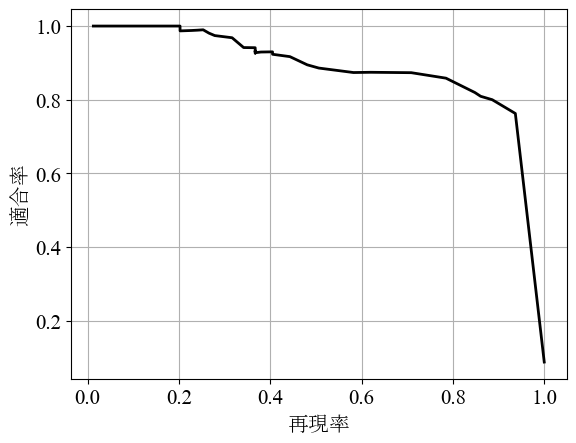

AUC：0.8702822446933516
理想の閾値：0.030769230769230767
F値（最高）：0.8408408408408408
適合率（最高）：0.8
再現率（最高）：0.8860759493670886


In [7]:
thr_bins=50
p_score, r_score, f_score, thresholds, thr, auc = fig_pr(target_v, target_sv, thr_bins)
print('\033[31m'+f'AUC：{auc}'+'\033[0m')
print(f'理想の閾値：{thr}')
print(f'F値（最高）：{f_score.max()}')
print(f'適合率（最高）：{p_score[np.argmax(f_score)]}')
print(f'再現率（最高）：{r_score[np.argmax(f_score)]}')

## 異常度可視化

In [8]:
p, r=validate(target_v, target_sv, thr)
print(f'適合率：{p}')
print(f'再現率：{r}')

abnorm=target_sv
figure(target_v, abnorm, target_sv, thr)

適合率：0.8
再現率：0.8860759493670886


## 異常度グラフズーム

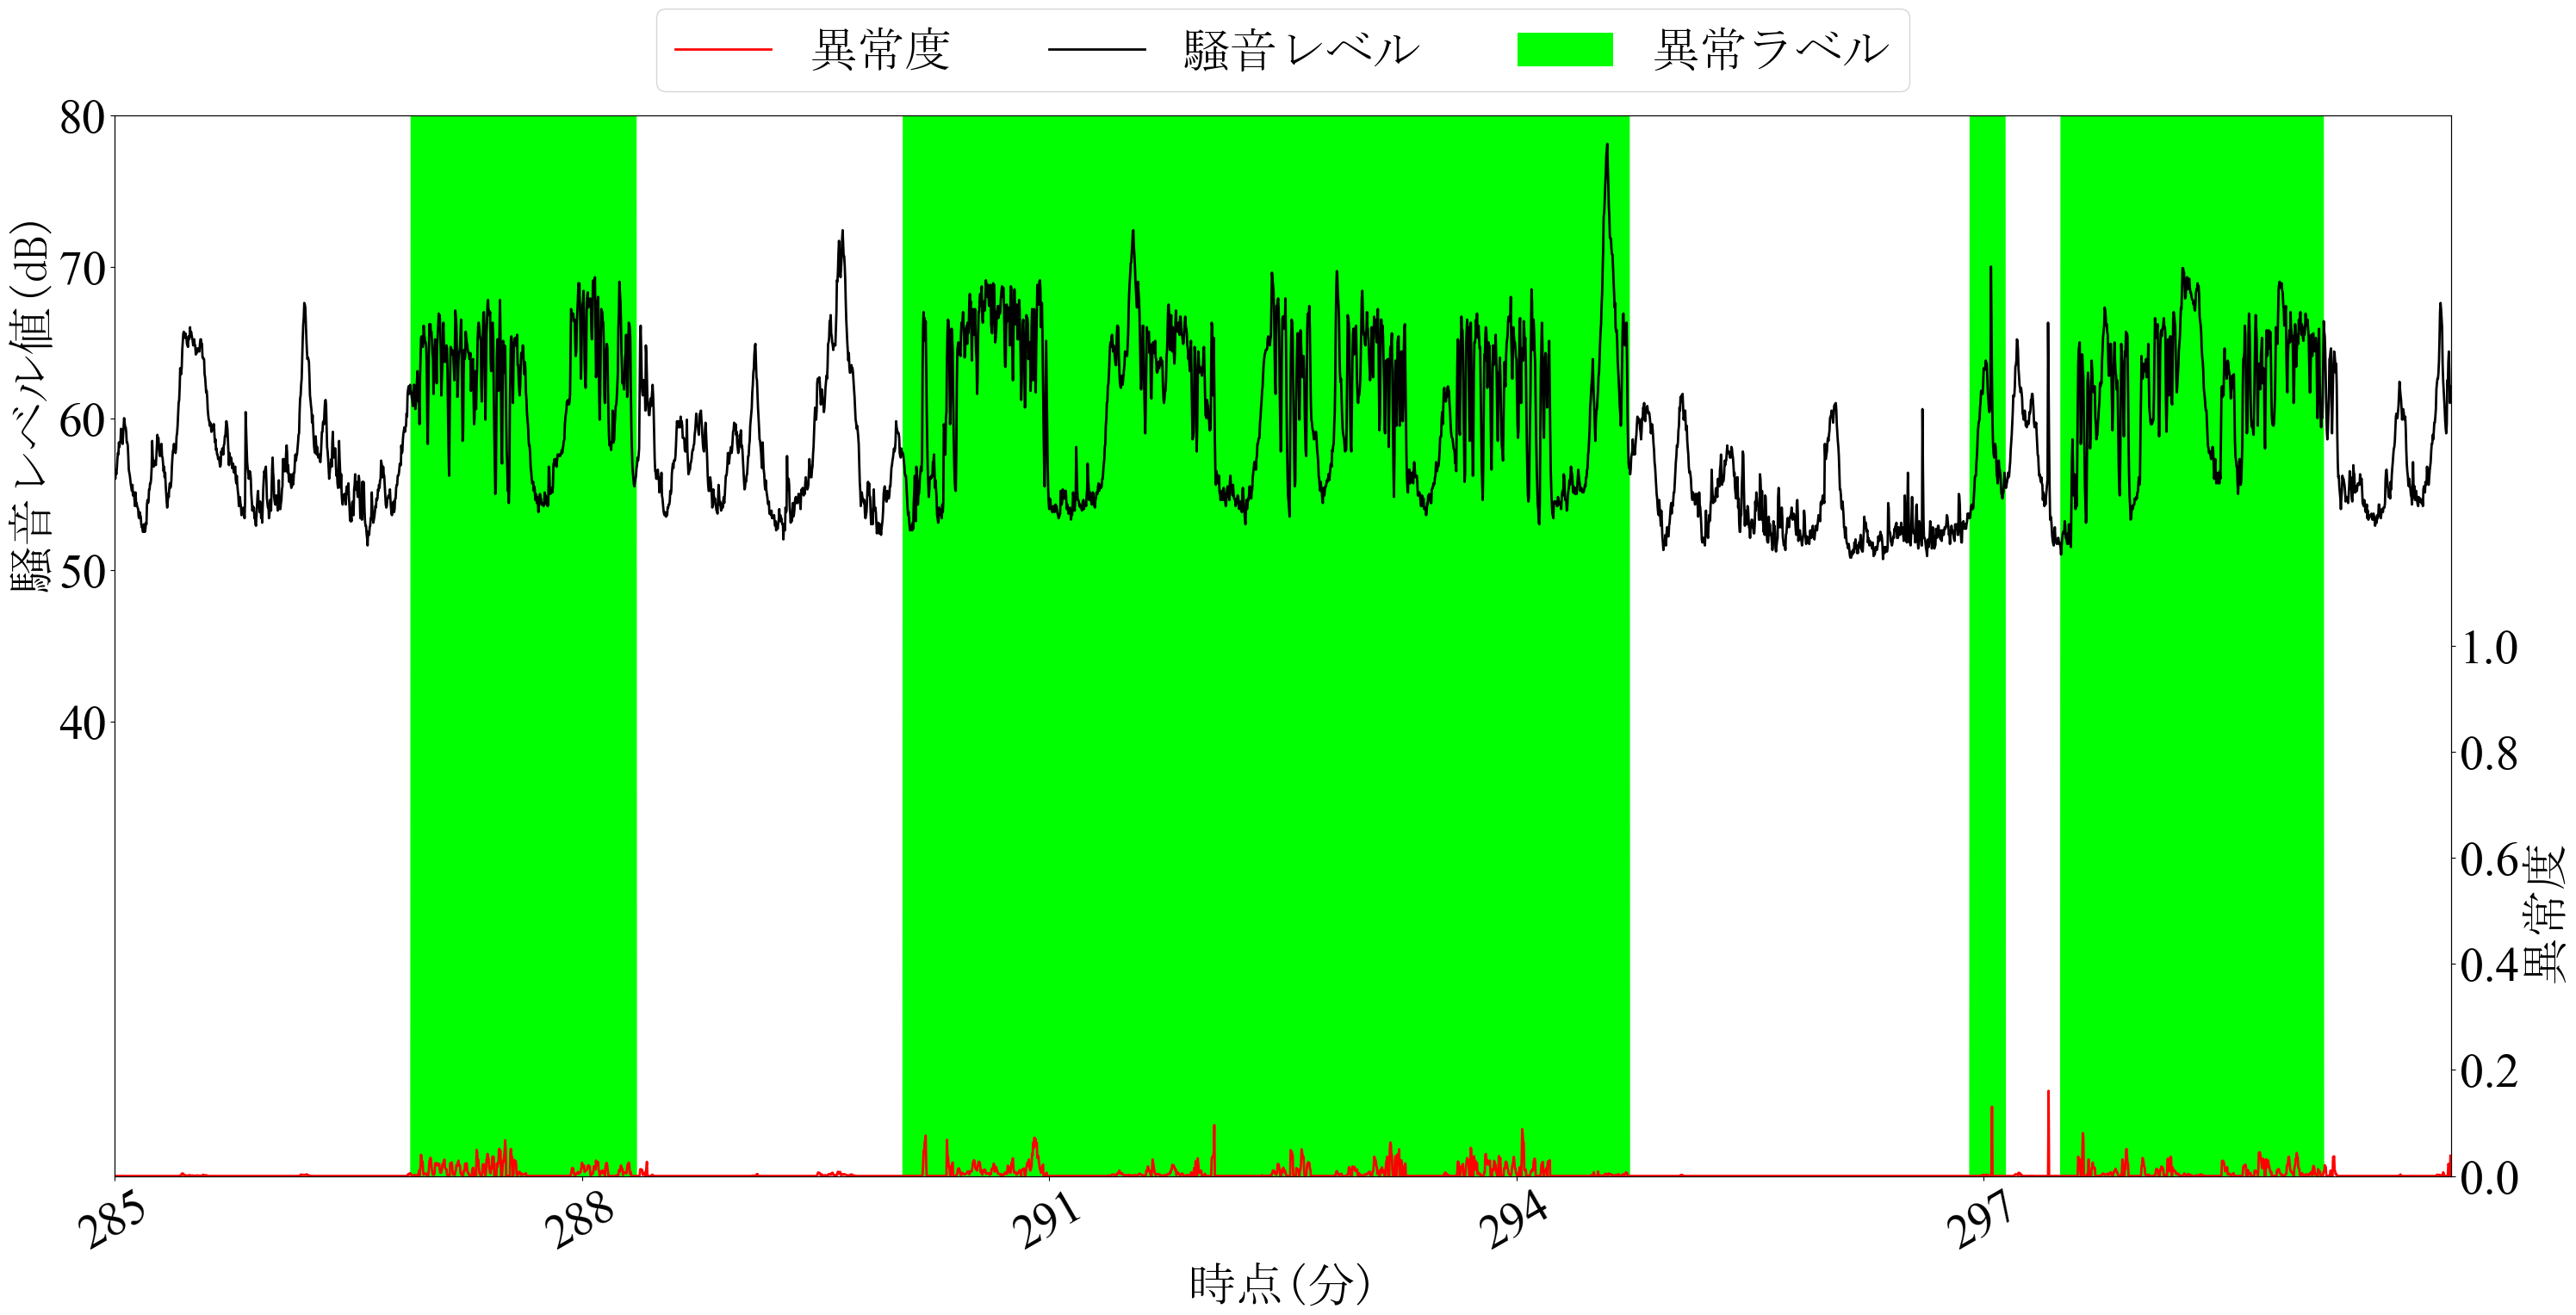

In [9]:
start=285
stop=300
figure_detail(target_v, target_sv, start, stop)

(0.0, 100.0)

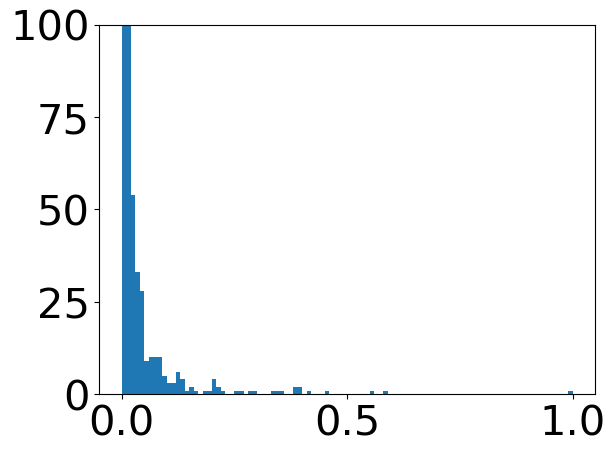

In [19]:
plt.hist(test_v['d'], bins=100)
plt.ylim(0, 100)